## Kernelized Support Vector Machines
### Modelos lineales con características no lineales

In [3]:
# Importamos paquetes
import pandas as pd
import numpy as np
import matplotlib
import scipy as sp
import matplotlib.pyplot as plt
import mglearn
from sklearn.datasets import make_blobs

Hemos visto que los modelos lineales pueden ser bastante limitados en espacios 2D, ya que las lineas e hiperplanos tienen una flexibilidad limitada. Una manera de hacer un modelo lineal más flexible, como hemos visto, es aplicar ingeniería de características añadiendo interacciones o procesamiento polinómico de las características de entrada.

Echemos un vistazo al dataset sintético que usamos para analiza la importancia de las características previamente:

Text(0, 0.5, 'Feature 1')

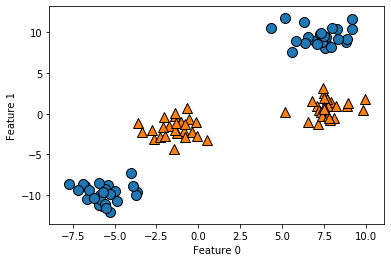

In [4]:
# from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Un modelo lineal de clasificación puede sólo separar puntos usando una línea, y no será por tanto capaz de hacer un buen trabajo en este dataset:

Text(0, 0.5, 'Feature 1')

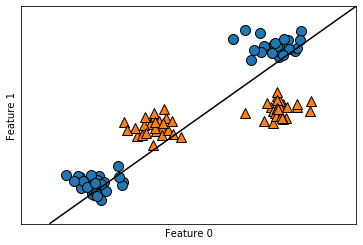

In [5]:
# Hacer una clasificación lineal sobre el dataset
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=10000).fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# La regresión lineal hace lo que puede y no es un modelo muy válido
# porque la frontera de desición no clasifica nada

Hagamos una expansión de las características de entrada, añadiendo también el cuadrado de la característica 1 como nueva característica. En vez de representar cada muestra como un punto bidimensional (característica 0, característica 1), la representamos como un punto 3D (característica 0, característica 1, característica 2 = (característica 1)^2):

Text(0.5, 0, '(característica 1)ˆ2')

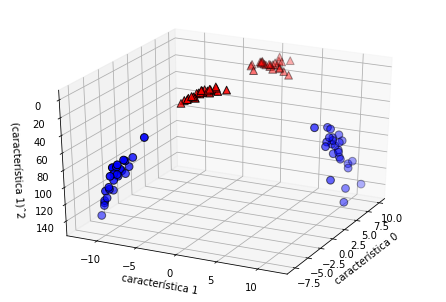

In [6]:
# Añadimos la primera característica elevada al cuadrado, para probar
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# Visualizamos en 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# Pintamos todos los puntos con y==0, y luego con y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2],
           c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("característica 0")
ax.set_ylabel("característica 1")
ax.set_zlabel("(característica 1)ˆ2")

En esta nueva representación de los datos sí es posible separar las dos clases usando un modelo lineal, la separación es un plano en tres dimensiones. Se puede confirmar esto haciendo un entrenamiento de un modelo lineal sobre el nuevo dataset aumentado:

Text(0.5, 0, '(Característica 1)^2')

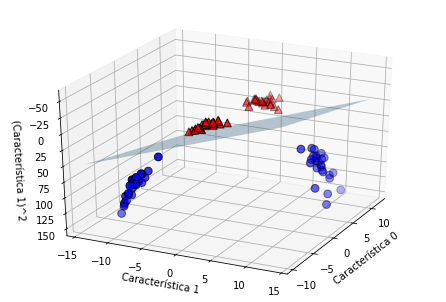

In [8]:
linear_svm_3d = LinearSVC(max_iter=10000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1],
           X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("Característica 0")
ax.set_ylabel("Característica 1")
ax.set_zlabel("(Característica 1)^2")

Considerado en función de la características originales, el modelo lineal SVM ya no es en realidad lineal. No es una línea sino una elipse, como puede verse a continuación:

Text(0, 0.5, 'Característica 1')

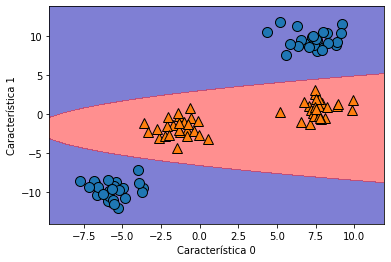

In [9]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(
    np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape),
             levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

### El truco del Kernel
La lección a a aprender aquí es que la adición de características no lineales a la representación de nuestros datos puede hacer que los modelos lineales sean muchos más potentes. Sin embargo, en muchas ocasiones no sabremos qué características tenemos que añadir, y añadir tantas como todas las interacciones posibles en, por ejemplo, un espacio de 100 dimensiones, es computacionalmente muy caro.

Afortunadamente, como hemos visto en la teoría de las presentaciones, hay un truco matemático muy conveniente  que nos permite entrenar un clasificador en un espacio dimensional más alto sin la necesidad de calcular esa nueva representación de los datos. Esto es lo que hemos visto ya que se conoce con el nombre de *kernel trick*, y funciona calculando directamente la distancia (más concretamente, el producto escalar) de las muestras en la representación expandida de las características, sin tener que llegar a calcular nunca esta representación.

Hay dos maneras de hacer el mapeo de los datos a un espacio dimensional más alto que son las más utilizadas con SMVs:

 - **Un kernel polinómico**, que computa todos los posibles polinomios hasta un grado dado de las características originales (tipo (característica 1)^2 * (característica 2)^5)
 - **Un kernel RBF (Radial Basis Function)**, también conocido como kernel Gaussiano. El kernel gaussiano es un poco más complicado de explicar (lo hemos intentado en el material de presentación del curso), ya que corresponde a un espacio de características de dimensión infinita. Una manera de explicar el kernel Gaussiano es decir que considera todos los posibles polinomios de todos los grados, pero que la importancia de las características decrece conforme crece el grado polinómico.

### Análisis de Support Vector Machines
\begin{align*}
\end{align*}
Durante el entrenamiento, SMV aprende cuán importante es cada uno de las muestras en la representación de la frontera de decisión entre las dos clases. Por norma general, sólo un subconjunto de las muestras de entrenamiento son importantes aquí: las que caen en el borde entre las dos clases, como ya hemos visto en la teoría. Éstas son las muestras que llamábamos vectores soporte y que dan a SVM su nombre.

Cuando vamos a hacer la predicción de un nuevo punto, lo que hace el modelo es medir la distancia a cada uno de los vectores soporte. La clasificación se realiza basándose en esas distancias y la importancia de las características que se aprendió durante la fase de entrenamiento (almacenada en el atributo `dual_coef_` del modelo).

Por defecto, la distancia entre las muestas se mide con el kernel Gaussiano:

$k_rbf(x_1, x_2) = e^{\gamma \left\Vert x_1 - x_2 \right\Vert ^ 2}$

En esta ecuación, $x_1$ y $x_2$ son muestras, $\left\Vert x_1 - X-2 \right\Vert$ denota la distancia euclídea, y $\gamma$ es un parámetro que controla la anchura del kernel Gaussiano.

A continuación se muestra el resultado del entrenamiento de SVM en un dataset bidimensional (*Forge* dataset). La frontera de decisión se muestra en negro, y los vectores soporte están remarcados:

Text(0, 0.5, 'Característica 1')

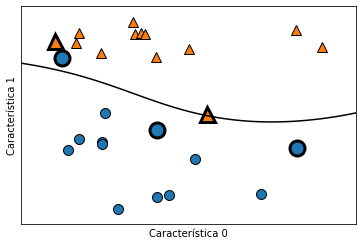

In [10]:
# Importamos SVC desde el módulo svm
from sklearn.svm import SVC

# Hacemos un dataset levemente modificado
X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

# Instanciamos y entrenamos un SVC con RBF, C=10 y gamma=0.1
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# Pintamos los vectores soporte
sv = svm.support_vectors_
# Las etiquetas de clase de los vectores vienen dadas por el signo de dual_coef
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1],
                         sv_labels, s=15,
                         markeredgewidth=3)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

# Nos muestra una curva suave que nos muestra los bordes soportes, tiene buena pinta como clasifica

En este caso, SMV produce una curva suave. Hemos ajustado dos parámetros, $C$ y $\gamma$, que vamos a ver ahora en detalle:

### Ajuste de los parámetros de SVM

El parámetro $\gamma$ es el que hemos mostrado en la fórmula anterior, y controla la anchura del kernel Gaussiano. Esto est básicamente determinar la escala de qué significa que dos puntos esté juntos. El parámetro $C$ es un parámetro de regularización, similar al utilizado en los modelos lineales, que limita la importancia de cada punto (y más específicamente, el valor `dual_coef_`).

Veamos que ocurre cuando vamos variando estos parámetros:

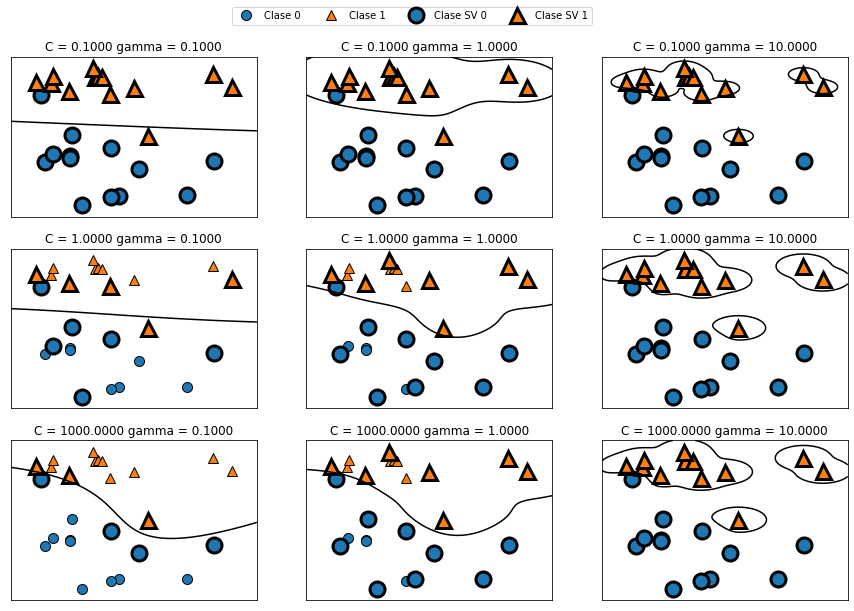

In [11]:
# Hacemos 6 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Iteramos para valores de C=0.1, 1 y 1000 en filas, y gamma -1, 0, 1 en columnas
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        # Nos apoyamos en una función ya definida para pintar los SVMs
        mglearn.plots.plot_svm(log_C=C, 
                               log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["Clase 0", "Clase 1",
                   "Clase SV 0", "Clase SV 1"],
                  ncol=4, loc=(.9, 1.2))
# En horizontal, vemos las variaciones desde un valor de gamma pequeño(tamaño del kernel) a grande
# En vertical, vemos las variaciones con C (parámetro de regularización), arriba tenemos un modelo muy restringido
# y abajo no

Yendo de izquierda a derecha, vamos incrementando el valor del parámetro $\gamma$ de 0.1 a 10. Un $\gamma$ pequeño implica un radio grande para el kernel Gaussiano, que significa que son muchos puntos los que se consideran en proximidad. Esto se refleja en fronteras de decisión más suaves a la izquierda, y más enfocadas en muestras concretas a medida que nos vamos moviendo a la derecha. Un valor bajo de $\gamma$ significa que la frontera de decisión variará lentamente, lo cual genera un modelo de baja complejidad, mientras que un valor alto de gamma generará modelos más complejos.

Yendo de arriba a abajo, incrementamos el valor del parámetro $C$ de 0.1 a 1000. Como en el caso de los modelos lineales, una $C$ pequeña implica un modelo muy restringido, donde cada punto de datos puede tener puede tener sólo una influencia muy limitada. Esto se puede arriba a la izquierda, donde la frontera de decisión parece casi lineal, con las muestras mal clasificadas apenas teniendo ninguna influencia sobre la línea. Al incrementar $C$, como ocurre en los gráficos de abajo, se permite que estos puntos tengan una influencia más fuerte sobre el modelo y esto provoca que la frontera de decisión se adapte para clasificarlos correctamente.

Apliquemos ahora SVM con kernel RBF al Breast Cancer dataset. Por defecto, $C=1$ y $\gamma = \frac{1}{\mathrm{n\_features}}$:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Partimos en test y training
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Instanciamos y entrenamos un SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

# Mostramos las precisiones
print("Precisión en el training set: {:.2f}"
      .format(svc.score(X_train, y_train)))
print("Precisión en el test set: {:.2f}"
      .format(svc.score(X_test, y_test)))

Precisión en el training set: 1.00
Precisión en el test set: 0.63


El modelo sobreajusta bastante, con una precisión perfecta en el training set y sólo un 63% de precisión en el test set. Aunque los modelos SVM se comportan muy bien, son muy sensibles al ajuste de los parámetros y al escalado de los datos. En particular, requieren que todas las características varíen dentro de una escala similar.

Echemos un vistazo a los valores mínimos y máximos de cada característica, graficados en espacio logarítmico:

Text(0, 0.5, 'Magnitud de la característica')

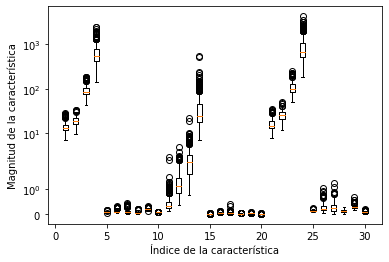

In [13]:
# Usamos un boxplot para mostrarlos
plt.boxplot(X_train, manage_ticks=False)
plt.yscale("symlog")
plt.xlabel("Índice de la característica")
plt.ylabel("Magnitud de la característica")

# Esto nso quiere decir que hay que hacer preprocesado, porque hay muchos tipos de magnitud,
# y esto afecta mucho al SVM

A partir de este gráfico podemos ver que las características en el Breast Cancer dataset son de órdenes de magnitud diferentes. Esto, que ya puede ser problemático para otros modelos (por ejemplo, modelos lineales), es devastador para kernel SVMs. Veamos algunas maneras de tratar con este problema, alguna de las cuales ya hemos adelantado en clase:

### Preprocesado de datos para SVMs
Una manera de resolver este problema es mediante el reescalado de cada característica, como ya se ha visto en otros ejercicios, para que todas permanezcan en el mismo rango de escala (hablamos también de esto en las [notas adicionales de clase](https://docs.google.com/document/d/1ywFwDW-M4g2Skt-gU0UQWsX6P5ITbvjTOuDl-eGchj8). Un método muy común utilizando en SVMs es escalar todas las características entre 0 y 1, lo que se puede hacer con el preprocesador `MinMaxScaler` de Scikit-Learn.

Con el ánimo de ilustrar exactamente qué hace este preprocesador, lo hacemos a continuación manualmente:

In [16]:
# Calculamos el valor mínimo de cada característica en el training set
min_on_training = X_train.min(axis=0)
# Calculamos el rango de cada característica
#(max - min) en el training set
range_on_training = (X_train - min_on_training).max(axis=0)

# Restamos el mínimo y dividimos por el rango
# después, min=0 y max=1 para cada caracterísitca
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Mínimo para cada característica\n",
      X_train_scaled.min(axis=0))
print("Máximo para cada característica\n",
      X_train_scaled.max(axis=0))

Mínimo para cada característica
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Máximo para cada característica
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [18]:
# Utilizamos la misma transformación en el test set,
# usando el mínimo y el rango del training set. See Chapter 3 (unsupervised learning) for details.
# usando el mínimo y el rango del training set.
X_test_scaled = (X_test - min_on_training) / range_on_training

Con estos cambios, probamos de nuevo a entrenar y evaluar el modelo:

In [19]:
# Instanciamos y entrenamos un SVC
svc = SVC(gamma='auto')
svc.fit(X_train_scaled, y_train)

# Mostramos las precisiones
print("Precisión en el training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Precisión en el test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Precisión en el training set: 0.948
Precisión en el test set: 0.951


Como puede verse, escalar los datos mejora enormemente los resultados. De hecho, ahora estamos en una situación de subajuste, donde ambos rendimientos de training y test son similares pero menos cercanos a 100%. Desde esta situación de partida, podemos intentar incrementar $C$ o $\gamma$ para ajustar con un modelo más complejo.

Por ejemplo:

In [21]:
# Entrena svc on C=1000
svc = SVC(C=1000,gamma='auto')
svc.fit(X_train_scaled, y_train)

# Muestra la precisión
print("Precisión en el training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(svc.score(X_test_scaled, y_test)))
# Se ve que ha funcionado muy bien el subir el C

Precisión en el training set: 0.988
Precisión en el test set: 0.972
